# Appendix D: Extended Generative Gallery
This notebook generates a grid of randomly sampled scenarios to demonstrate
the robustness and diversity of the Deep-Flow generative process.

We select scenarios with significant movement (> 10m displacement) to showcase
the Goal-Conditioned Flow capabilities.

In [1]:
import matplotlib
if not hasattr(matplotlib.RcParams, '_get'):
    matplotlib.RcParams._get = lambda self, key: self.get(key)

import matplotlib.pyplot as plt
import torch
import numpy as np
import json
import random
from omegaconf import OmegaConf
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.models.deep_flow import DeepFlow
from src.dataset.waymo_dataset import WaymoDataset
from src.utils.visualization import plot_scenario

In [2]:
# ## 1. Setup Model & Data

# %%
cfg = OmegaConf.load("../configs/main_config.yaml")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load PCA Basis
pca_path = "/mnt/d/waymo_datasets/Deep-Flow_Dataset/pca_basis.json"
with open(pca_path, "r") as f:
    pca_data = json.load(f)

PCA_COMP = torch.tensor(pca_data['components'], device=device).float()
PCA_MEAN = torch.tensor(pca_data['mean'], device=device).float()
PCA_STDS = torch.tensor(pca_data['stds'], device=device).float()
SCALE_POS = 50.0

# Load Model
model = DeepFlow(cfg).to(device)
checkpoint = torch.load("../checkpoints/best_model.pth", map_location=device)
model.load_state_dict(checkpoint['model'])
model.eval()

# Load Data
print("Loading validation set...")
val_set = WaymoDataset(cfg, split='validation', in_memory=True)


/home/anton/Deep-Flow/.venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Loading validation set...
🚀 Parallel Eager Load (20 workers)...


100%|██████████| 8856/8856 [00:20<00:00, 427.27it/s]

✅ validation split loaded. Count: 8856


In [11]:
# ## 2. Generative Engine
# (Reusing the calibrated logic from notebook 02)

# %%
# @torch.no_grad()
# def generate(model, batch_torch, num_samples=15, steps=30):
#     # 1. Encode
#     context, goal_emb = model.encoder(
#         batch_torch['agent_context'], 
#         batch_torch['agent_mask'], 
#         batch_torch['map_context'], 
#         batch_torch['map_mask'],
#         batch_torch['goal_pos'],
#         batch_torch['goal_lane']
#     )
    
#     # Tile for sampling
#     context = context.repeat(num_samples, 1)
#     goal_emb = goal_emb.repeat(num_samples, 1)

#     # 2. Integrate in 12D Manifold
#     curr_coeffs = torch.randn(num_samples, 12, device=device)
#     dt = 1.0 / steps
    
#     for i in range(steps):
#         t_tensor = torch.ones(num_samples, device=device) * (i * dt)
#         v_t = model.flow_head(curr_coeffs, t_tensor, context, goal_emb)
#         curr_coeffs = curr_coeffs + v_t * dt

#     # 3. Reconstruct
#     # Un-whiten -> Inverse PCA -> Un-scale
#     curr_coeffs = curr_coeffs * PCA_STDS
#     trajs_norm = torch.matmul(curr_coeffs, PCA_COMP) + PCA_MEAN
#     trajs_meters = trajs_norm.view(num_samples, 80, 2) * SCALE_POS
    
#     return trajs_meters.cpu().numpy()

@torch.no_grad()
def generate(model, batch_torch, num_samples=20, steps=30):
    device = next(model.parameters()).device
    
    # 1. Load PCA Basis (Now 12 components)
    pca_path = "/mnt/d/waymo_datasets/Deep-Flow_Dataset/pca_basis.json"
    import json
    with open(pca_path, "r") as f:
        pca_data = json.load(f)
        
    pca_comp = torch.tensor(pca_data['components'], device=device).float() # [12, 160]
    pca_mean = torch.tensor(pca_data['mean'], device=device).float()       # [160]
    # We load stds but we won't use them if we stopped whitening in the trainer
    
    SCALE_POS = 50.0 

    # 2. Encode Scene (Returns Tuple now)
    context, goal_emb = model.encoder(
        batch_torch['agent_context'], 
        batch_torch['agent_mask'], 
        batch_torch['map_context'], 
        batch_torch['map_mask'],
        batch_torch['goal_pos'],
        batch_torch['goal_lane']
    )
    
    context = context.repeat(num_samples, 1)
    goal_emb = goal_emb.repeat(num_samples, 1)

    # 3. Integrate in 12D PCA space
    curr_coeffs = torch.randn(num_samples, 12, device=device) # Updated to 12
    dt = 1.0 / steps
    
    for i in range(steps):
        t = torch.ones(num_samples, device=device) * (i * dt)
        # Head now expects 4 arguments: (xt, t, context, goal_emb)
        v_t = model.flow_head(curr_coeffs, t, context, goal_emb)
        curr_coeffs = curr_coeffs + v_t * dt

    # 4. RECONSTRUCTION
    # CRITICAL: We NO LONGER multiply by PCA_STDS here 
    # because the trainer is now learning raw PCA coefficients.
    
    # Inverse PCA: [Samples, 12] @ [12, 160] + [160]
    trajs_norm = torch.matmul(curr_coeffs, pca_comp) + pca_mean
    
    # Un-scale to Meters
    trajs_meters = trajs_norm.view(num_samples, 80, 2) * SCALE_POS 
    
    return trajs_meters.cpu().numpy()


Scanning for interesting scenarios...
Total validation scenarios: 8856. Scanning for candidates with >10m displacement...
Selected 9 scenarios.


100%|██████████| 9/9 [00:00<00:00, 11.83it/s]


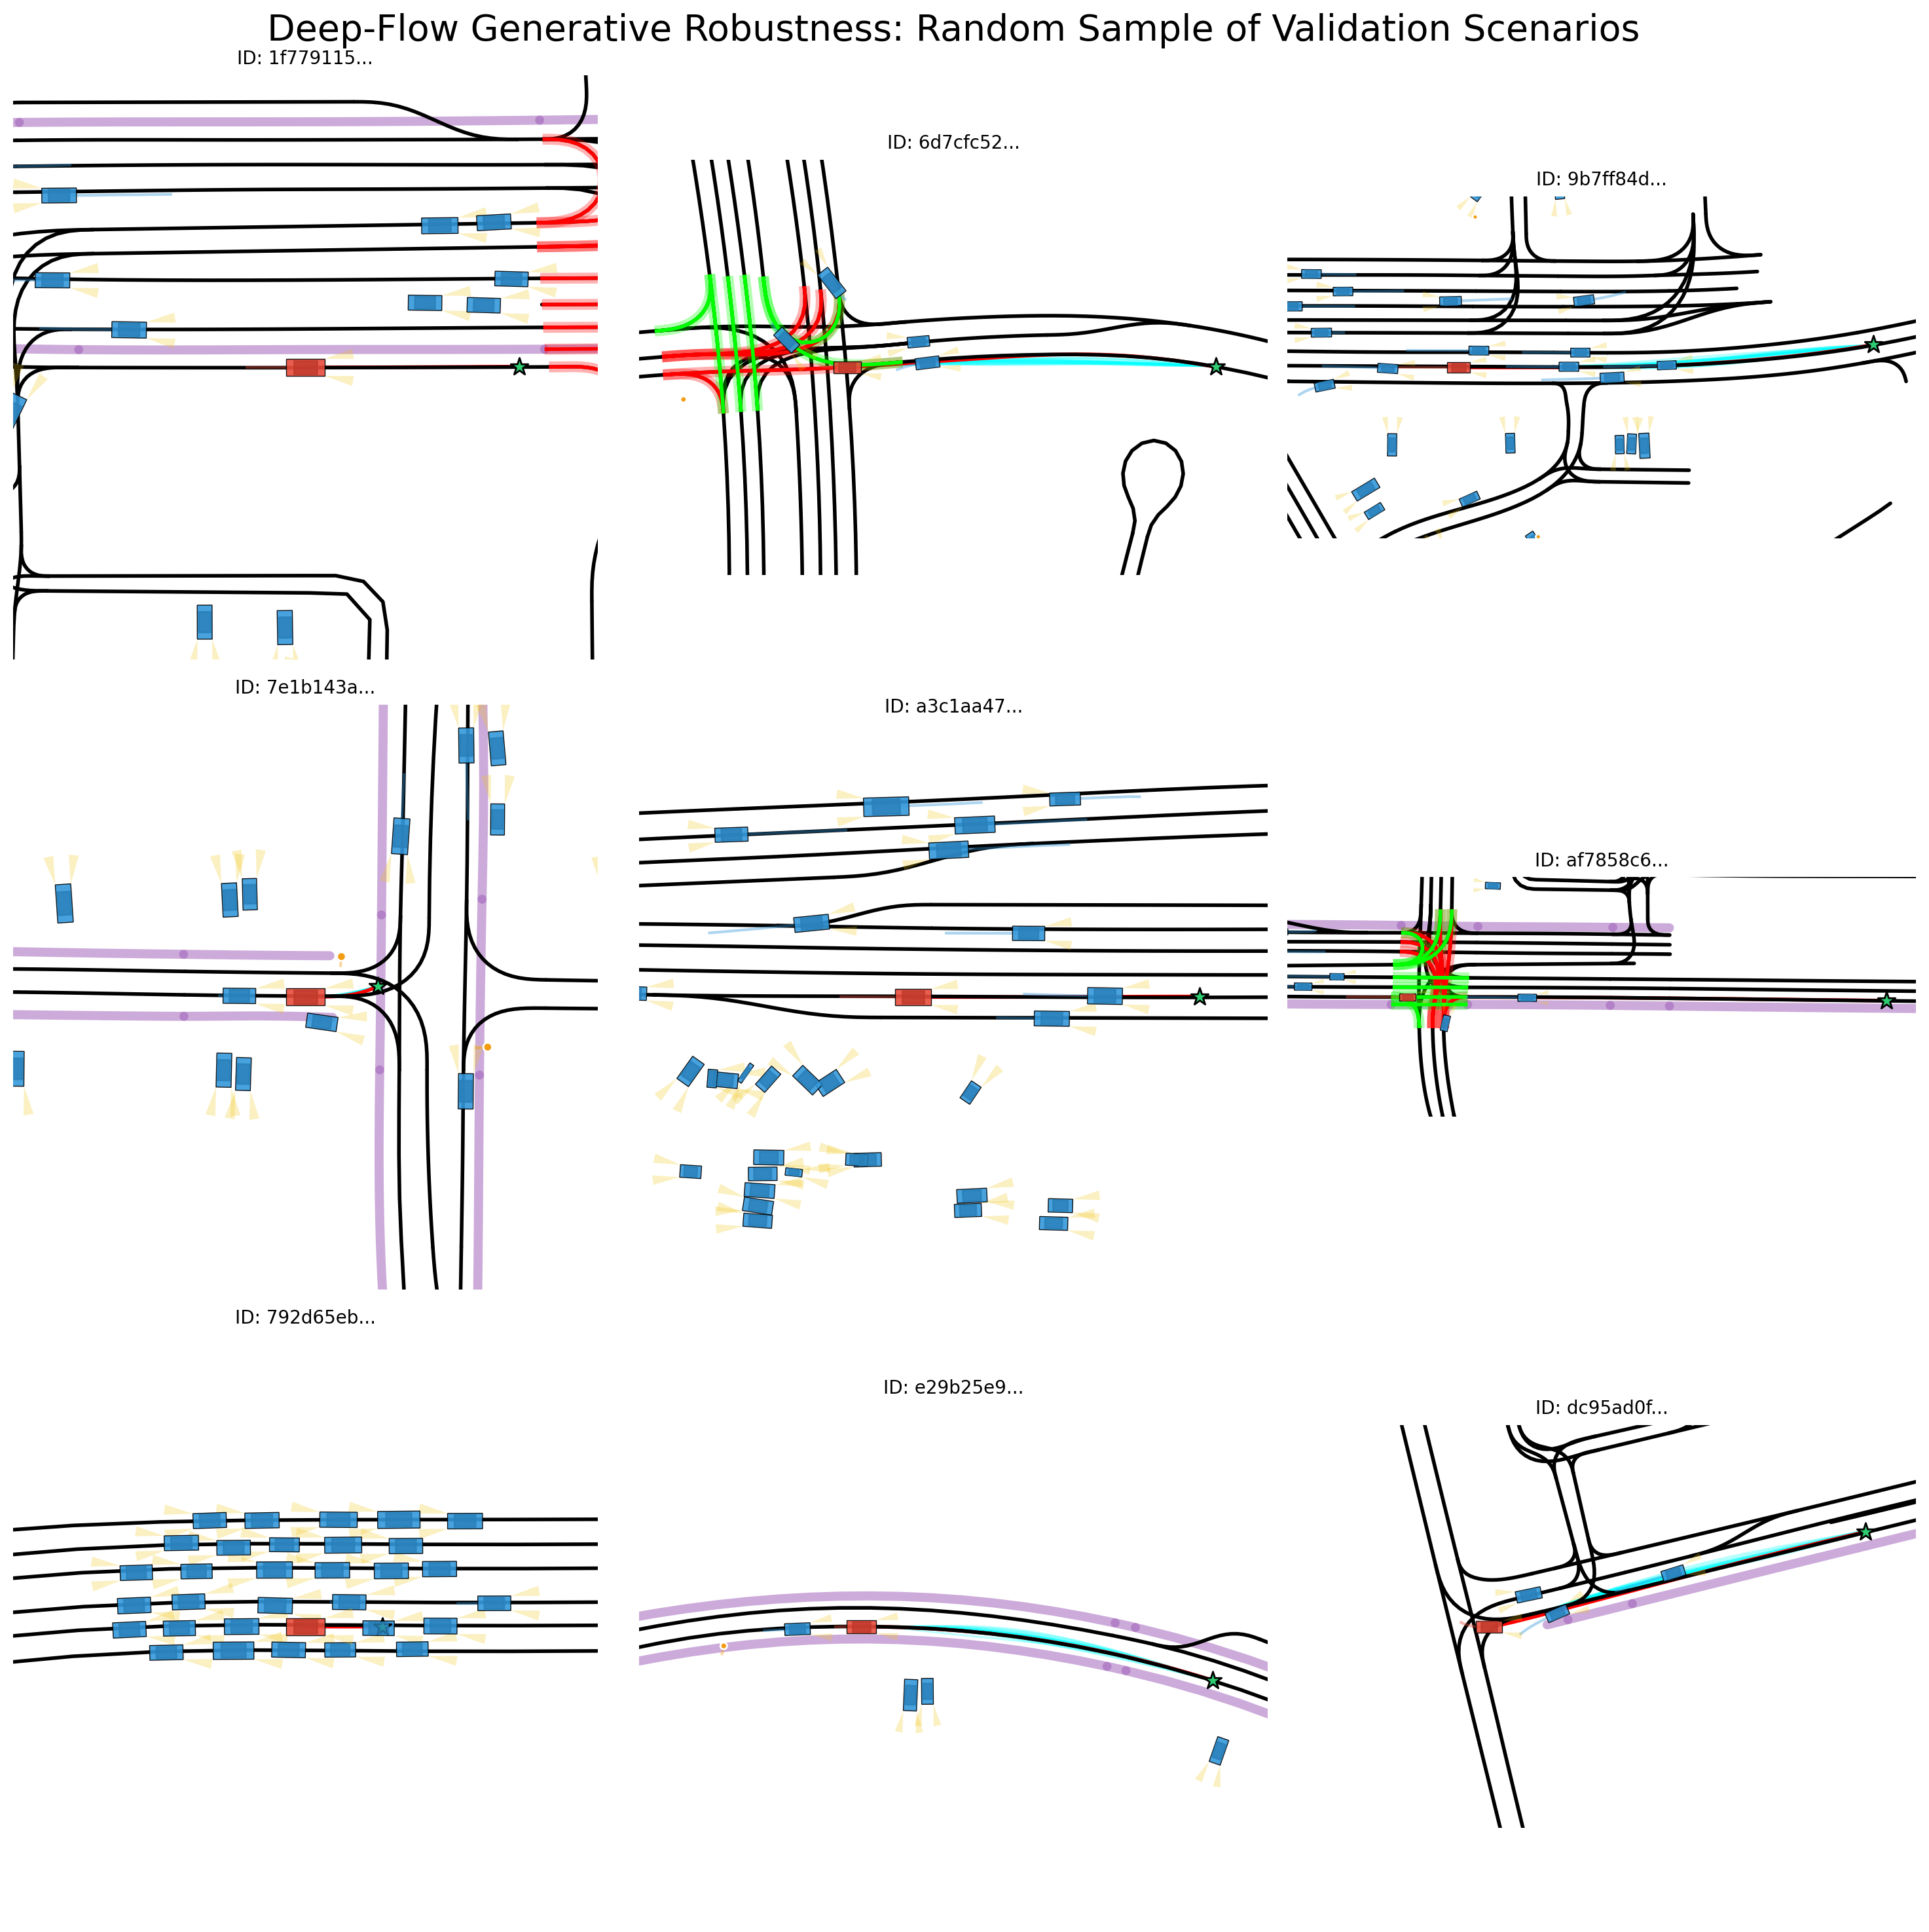

In [ ]:
# ## 3. Generate the Gallery
# We filter for "interesting" scenarios (moving cars) and plot a 3x5 grid.

# %%
# Configuration
ROWS = 3
COLS = 3
NUM_PLOTS = ROWS * COLS

# Filter for moving scenarios (Displacement > 10m)
# This prevents filling the gallery with parked cars
candidates = []
print("Scanning for interesting scenarios...")
# Random shuffle indices to get diversity
indices = list(range(len(val_set)))
random.shuffle(indices)

print(f"Total validation scenarios: {len(val_set)}. Scanning for candidates with >10m displacement...")

for idx in indices:
    batch = val_set[idx]
    # goal_pos is normalized. * 50 = meters. Magnitude check.
    disp = np.linalg.norm(batch['goal_pos']) * 50.0
    if disp > 10.0:
        candidates.append(idx)
    if len(candidates) >= NUM_PLOTS:
        break

print(f"Selected {len(candidates)} scenarios.")

# Plotting
fig, axes = plt.subplots(ROWS, COLS, figsize=(15, 15))
axes = axes.flatten()

for i, idx in enumerate(tqdm(candidates)):
    ax = axes[i]
    
    # Load Data
    batch = val_set[idx]
    # Find Raw Data for Map Rendering
    raw_path = next((p for p in val_set.file_list if batch['scenario_id'] in p), None)
    if raw_path:
        raw_data = np.load(raw_path)
    else:
        continue # Skip if file not found
        
    # Prepare Batch
    batch_torch = {k: v.unsqueeze(0).to(device) if isinstance(v, torch.Tensor) else v 
                   for k, v in batch.items()}
    
    # Run Inference
    hallucinations = generate(model, batch_torch)
    
    # Plot Map
    plot_scenario(raw_data, ax=ax, show_future=False)
    
    # Plot Hallucinations (Cyan)
    for h in hallucinations:
        ax.plot(h[:, 0], h[:, 1], color='cyan', alpha=0.3, linewidth=1)
        
    # Plot GT (Red)
    gt = raw_data['agents'][0, 11:91, :2]
    ax.plot(gt[:, 0], gt[:, 1], color='red', linewidth=2, label='GT')
    
    # Plot Goal (Green Star)
    goal = gt[-1]
    ax.scatter(goal[0], goal[1], color='#2ecc71', s=100, marker='*', edgecolors='black', zorder=10)
    
    # Clean up axes
    ax.set_title(f"ID: {batch['scenario_id'][:8]}...", fontsize=10)
    threshold = 10  # Define a threshold value
    x_min = min(-40, goal[0] - threshold)
    x_max = max(40, goal[0] + threshold)
    y_min = min(-40, goal[1] - threshold)
    y_max = max(40, goal[1] + threshold)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.axis('off') # Hide axis ticks for cleaner gallery look

plt.suptitle("Deep-Flow Generative Robustness: Random Sample of Validation Scenarios", fontsize=20)
plt.tight_layout()
plt.savefig("../results/appendix_gallery_3.pdf", dpi=150, bbox_inches='tight')
plt.show()